In [1]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the zip file in your Google Drive
zip_file_path = '/content/drive/My Drive/INSTA_UI/INSTAUI.zip'  # Update this path with the location of your zip file

# Define the directory to extract the zip file
extract_to_path = '/content/extracted_files'

# Ensure the directory exists
os.makedirs(extract_to_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to: {extract_to_path}")

Mounted at /content/drive
Files extracted to: /content/extracted_files


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


Epoch 1/13, Loss: 0.0908
Epoch 2/13, Loss: 0.0020
Epoch 3/13, Loss: 0.0020
Epoch 4/13, Loss: 0.0019
Epoch 5/13, Loss: 0.0018
Epoch 6/13, Loss: 0.0012
Epoch 7/13, Loss: 0.0008
Epoch 8/13, Loss: 0.0010
Epoch 9/13, Loss: 0.0014
Epoch 10/13, Loss: 0.0014
Epoch 11/13, Loss: 0.0010
Epoch 12/13, Loss: 0.0007
Epoch 13/13, Loss: 0.0009


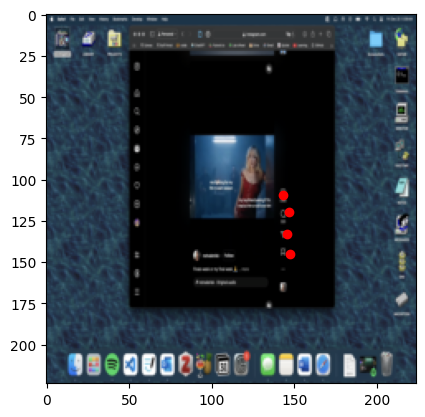

In [2]:
import os
import json
import cv2
import torch
import torchvision.transforms as T
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np

class KeypointDataset(Dataset):
    def __init__(self, json_path, img_dir, transform=None):
        with open(json_path, 'r') as f:
            raw_data = json.load(f)

        self.valid_data = []
        for idx, entry in enumerate(raw_data):
            try:
                annotations = entry['annotations'][0]['result']
                if len(annotations) == 4:
                    self.valid_data.append(entry)
            except Exception as e:
                print(f"Skipping invalid data at index {idx}: {e}")

        self.img_dir = img_dir
        self.transform = transform

        preprocessed_dir = img_dir + '_preprocessed'
        os.makedirs(preprocessed_dir, exist_ok=True)

        # Save preprocessed data and create file list
        self.files = []
        for idx, entry in enumerate(self.valid_data):  # Use valid_data to ensure consistency
            try:
                # Load and preprocess image
                img_path = os.path.join(img_dir, entry['data']['img'].split('/')[-1])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = transform(img).numpy()

                # Process keypoints
                annotations = entry['annotations'][0]['result']
                keypoints = []
                for kp in annotations:
                    x = kp['value']['x'] / 100
                    y = kp['value']['y'] / 100
                    keypoints.extend([x, y])
                keypoints = np.array(keypoints, dtype=np.float32)

                # Save processed data
                file_path = os.path.join(preprocessed_dir, f"data_{idx}.npz")
                np.savez(file_path, img=img, keypoints=keypoints)
                self.files.append(file_path)
            except Exception as e:
                print(f"Skipping index {idx}: {e}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        img = torch.tensor(data['img'], dtype=torch.float32)
        keypoints = torch.tensor(data['keypoints'], dtype=torch.float32)
        return img, keypoints


transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

json_path = '/content/extracted_files/INSTAUI/instaUI.json'
img_dir = '/content/extracted_files/INSTAUI/ImageExport'
dataset = KeypointDataset(json_path, img_dir, transform=transform)
valid_indices = []
for i in range(len(dataset)):
    try:
        _ = dataset[i]
        valid_indices.append(i)
    except IndexError:
        continue

filtered_dataset = torch.utils.data.Subset(dataset, valid_indices)
dataloader = DataLoader(filtered_dataset, batch_size=16, shuffle=True)

class KeypointModel(nn.Module):
    def __init__(self):
        super(KeypointModel, self).__init__()
        self.backbone = resnet18(weights="ResNet18_Weights.DEFAULT")
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 8)

    def forward(self, x):
        return self.backbone(x)

model = KeypointModel()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(len(dataset)):
    img, keypoints = dataset[i]
    if img is None:
        print(f"Skipping invalid data at index {i}")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 13
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, keypoints in dataloader:
        images, keypoints = images.to(device), keypoints.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, keypoints)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

def visualize_predictions(model, dataset, device):
    model.eval()
    img, keypoints = dataset[0]
    img = img.to(device).unsqueeze(0)
    with torch.no_grad():
        pred_keypoints = model(img).cpu().numpy().reshape(-1, 2)

    img = img.cpu().squeeze().permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

    plt.imshow(img)
    for (x, y) in pred_keypoints:
        plt.scatter(x * img.shape[1], y * img.shape[0], c='r')
    plt.show()

visualize_predictions(model, dataset, device)

In [4]:
from google.colab import files

# Save the model state_dict
torch.save(model.state_dict(), 'keypoint_model.pth')

# Download the file to your local computer
files.download('keypoint_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>